<a href="https://colab.research.google.com/github/brentwilder/Test-Area/blob/master/COLAB/GEE_TSARS_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NO2 concentrations in Downtown LA during COVID-19 lockdown using GEE
## TSARS Seminar, Spring 2022

![LA](https://content.presspage.com/uploads/2110/1920_los-angeles-cedars-sinai-covid-gettyimages2.jpg?10000)



In [ ]:
# Run all of the things needed to get GEE going in colab
# Important! This will ask you to open a link an insert your GEE Credentials!
from google.colab import auth
auth.authenticate_user()
import ee
ee.Initialize()
import geemap 

# Also load in some other libraries needed for this notebook
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats
!pip install -q geopandas
import geopandas as gpd

# First, let's look at an interactive map of the data!

#### Information on the Nitrogen Dioxide data can be found here: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_OFFL_L3_NO2#description

In [ ]:
# Define our area of interest (Los Angeles , California)
# Feel free to add your own bounding box if you have another area in mind!
area = ee.Feature(ee.Geometry.Rectangle(-118.74553648325988, 33.59967040156815,-117.06188169810363 ,34.3784997410474))

In [ ]:
# Load images for March 2019, March 2020, March 2021, and March 2022
March2019 = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_NO2').select('tropospheric_NO2_column_number_density').filterDate('2019-03-01', '2019-04-01')
March2020 = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_NO2').select('tropospheric_NO2_column_number_density').filterDate('2020-03-01', '2020-04-01')
March2021 = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_NO2').select('tropospheric_NO2_column_number_density').filterDate('2021-03-01', '2021-04-01')
March2022 = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_NO2').select('tropospheric_NO2_column_number_density').filterDate('2022-03-01', '2022-04-01')

# Composite those images by taking the mean, clip them to area, and set default projection of original image
March2019 = March2019.mean().setDefaultProjection(March2019.first().projection()).clip(area)
March2020 = March2020.mean().setDefaultProjection(March2020.first().projection()).clip(area)
March2021 = March2021.mean().setDefaultProjection(March2021.first().projection()).clip(area)
March2022 = March2022.mean().setDefaultProjection(March2022.first().projection()).clip(area)

In [ ]:
# Create a geemap object for plotting to
# NOTE: You can adjust the visbile layers by clicking on the wrench in the top right corner , then the layers tab
Map = geemap.Map()

# Set the visuals for our map (for this data the range is reaally small 0-0.0002)
vis_params = {'min': 0, 'max': 0.0002, 'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']}

# Add Earth Engine layers to Map
Map.addLayer(March2019,vis_params,'March 2019 NO2')
Map.addLayer(March2020,vis_params,'March 2020 NO2')
Map.addLayer(March2021,vis_params,'March 2021 NO2')
Map.addLayer(March2022,vis_params,'March 2022 NO2')
Map.centerObject(March2020, 9) # set map center on our location

# Set parameters for the color bar
colors = vis_params['palette']
vmin = vis_params['min']
vmax = vis_params['max']
Map.add_colorbar_branca(colors=colors,vmin=vmin,vmax=vmax,layer_name="NO2 (column number density)")
Map.addLayerControl()
Map

Map(center=[33.99135671299309, -117.90370909068172], controls=(WidgetControl(options=['position', 'transparent…

# Next, we convert the Earth Engine object into a 2d Numpy array to make plotting and statistics more accessible

In [ ]:
# NOTE: this entire cell here contains borrowed functions from https://mygeoblog.com/2019/08/21/google-earth-engine-to-numpy/
# It turns out there is not really a great function currently to extract the data and also retain the lat / lon information...
# if anyone knows of any new functions definitely share!

# export the latitude, longitude and array
def LatLonImg(img):
    img = img.addBands(ee.Image.pixelLonLat())
 
    img = img.reduceRegion(reducer=ee.Reducer.toList(),geometry=area.geometry())
 
    data = np.array((ee.Array(img.get("tropospheric_NO2_column_number_density")).getInfo()))
    lats = np.array((ee.Array(img.get("latitude")).getInfo()))
    lons = np.array((ee.Array(img.get("longitude")).getInfo()))
    return lats, lons, data
 
# covert the lat, lon and array into an image
def toImage(lats,lons,data):
 
    # get the unique coordinates
    uniqueLats = np.unique(lats)
    uniqueLons = np.unique(lons)
 
    # get number of columns and rows from coordinates
    ncols = len(uniqueLons)
    nrows = len(uniqueLats)
 
    # determine pixelsizes
    ys = uniqueLats[1] - uniqueLats[0]
    xs = uniqueLons[1] - uniqueLons[0]
 
    # create an array with dimensions of image
    arr = np.zeros([nrows, ncols], np.float32) #-9999
 
    # fill the array with values
    counter =0
    for y in range(0,len(arr),1):
        for x in range(0,len(arr[0]),1):
            if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
                counter+=1
                arr[len(uniqueLats)-1-y,x] = data[counter] # we start from lower left corner
    return arr

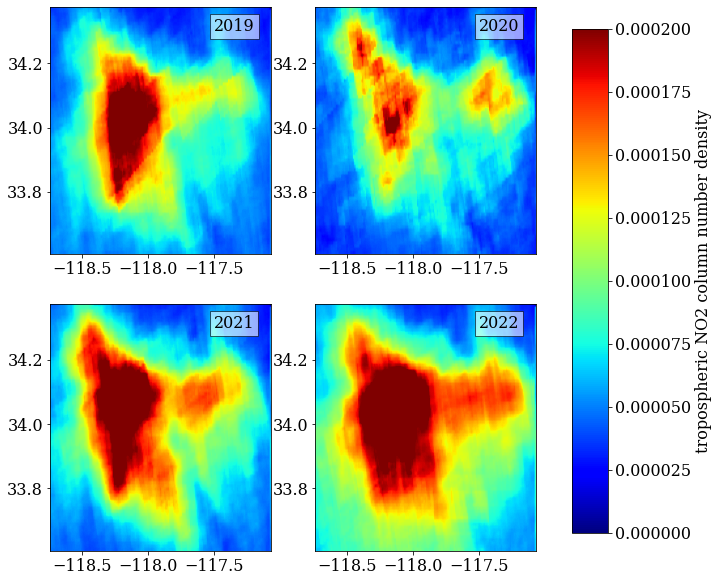

In [ ]:
# Create subplots of the four images for publication/conference style 
# Set font size and font family
plt.rcParams.update({'font.size': 16})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# Create figure object, axes, and subplots
fig, ax = plt.subplots(2,2,figsize =(10, 10))


## TOP LEFT PLOT ########
# get the lon, lat and result as 1d array
lat, lon, data = LatLonImg(March2019)

# 1d to 2d array
image2019  = toImage(lat,lon,data)
ax[0,0].imshow(image2019, extent=[lon.min(), lon.max(), lat.min(),lat.max()],vmin=0, vmax=0.0002, cmap='jet', aspect='auto')
ax[0,0].text(-117.5,34.3,'2019',bbox=dict(facecolor='white', alpha=0.6))

## TOP RIGHT PLOT ########
# get the lon, lat and result as 1d array
lat, lon, data = LatLonImg(March2020)
# 1d to 2d array
image2020 = toImage(lat,lon,data)
ax[0,1].imshow(image2020, extent=[lon.min(), lon.max(), lat.min(),lat.max()],vmin=0, vmax=0.0002, cmap='jet', aspect='auto')
ax[0,1].text(-117.5,34.3,'2020',bbox=dict(facecolor='white', alpha=0.6))

## BOTTOM LEFT PLOT ########
# get the lon, lat and result as 1d array
lat, lon, data = LatLonImg(March2021)
# 1d to 2d array
image2021 = toImage(lat,lon,data)
ax[1,0].imshow(image2021, extent=[lon.min(), lon.max(), lat.min(),lat.max()],vmin=0, vmax=0.0002, cmap='jet', aspect='auto')
ax[1,0].text(-117.5,34.3,'2021',bbox=dict(facecolor='white', alpha=0.6))

## BOTTOM RIGHT PLOT ########
# get the lon, lat and result as 1d array
lat, lon, data = LatLonImg(March2022)
# 1d to 2d array
image2022 = toImage(lat,lon,data)
sp = ax[1,1].imshow(image2022, extent=[lon.min(), lon.max(), lat.min(),lat.max()],vmin=0, vmax=0.0002, cmap='jet', aspect='auto')
ax[1,1].text(-117.5,34.3,'2022',bbox=dict(facecolor='white', alpha=0.6))

# Adjust the color bar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(sp, cax=cbar_ax,label='tropospheric NO2 column number density')

plt.show()

In [ ]:
# We can also look at this again, but this time adding in a roads shapefile!
# this is only of primary and secondary roads as defined by TIGER:
# https://catalog.data.gov/dataset/tiger-line-shapefile-2019-state-california-primary-and-secondary-roads-state-based-shapefile
roads = gpd.read_file('/vsicurl/https://github.com/brentwilder/Test-Area/raw/master/COLAB/data/tl_2019_06_prisecroads.shp')
roads

,LINEARID,FULLNAME,RTTYP,MTFCC,geometry
0,1108301336873,Brawley Byp,M,S1200,"LINESTRING (-115.50116 32.97863, -115.50117 32..."
1,1108296979873,Reeves Byp,M,S1200,"LINESTRING (-119.91564 36.26536, -119.91558 36..."
2,1108296282474,Lincoln Byp,M,S1100,"LINESTRING (-121.29951 38.85805, -121.29952 38..."
3,1108296281364,Roseville Byp,M,S1100,"LINESTRING (-121.30031 38.81831, -121.30032 38..."
4,1108296281294,Roseville Byp,M,S1100,"LINESTRING (-121.30017 38.83067, -121.30017 38..."
...,...,...,...,...,...
7398,1105598254770,Ryer Ave,M,S1200,"LINESTRING (-121.63063 38.31316, -121.63062 38..."
7399,1104471475589,State Rte 84,S,S1200,"LINESTRING (-121.54237 38.54725, -121.54232 38..."
7400,1104471475590,State Rte 84,S,S1200,"LINESTRING (-121.52458 38.57550, -121.52441 38..."
7401,1104471474154,Reed Ave,M,S1200,"LINESTRING (-121.54538 38.59159, -121.54554 38..."


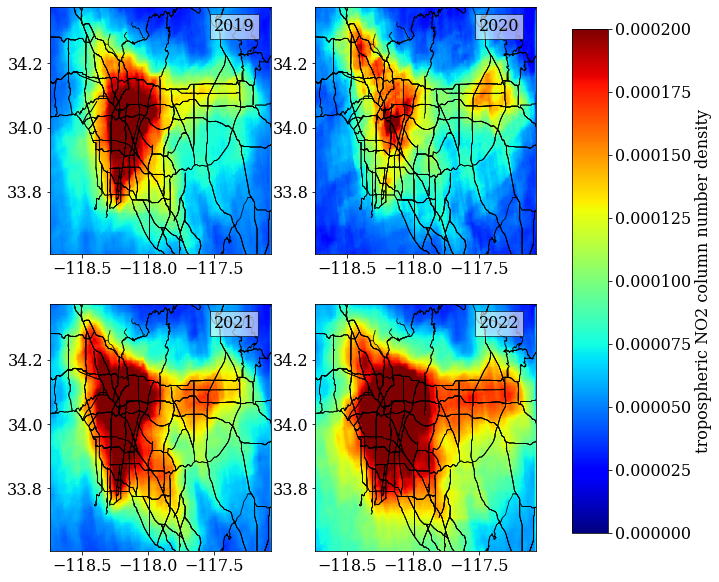

In [ ]:
# Overlaying all this geometry on our NO2 we can get a cool visulations of our major drivers ;)




# Create subplots of the four images for publication/conference style 
# Set font size and font family
plt.rcParams.update({'font.size': 16})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# Create figure object, axes, and subplots
fig, ax = plt.subplots(2,2,figsize =(10, 10))


## TOP LEFT PLOT ########
# get the lon, lat and result as 1d array
lat, lon, data = LatLonImg(March2019)

# 1d to 2d array
image2019  = toImage(lat,lon,data)
roads.plot(ax=ax[0,0],color='k',linewidth=0.75)
ax[0,0].imshow(image2019, extent=[lon.min(), lon.max(), lat.min(),lat.max()],vmin=0, vmax=0.0002, cmap='jet', aspect='auto')
ax[0,0].text(-117.5,34.3,'2019',bbox=dict(facecolor='white', alpha=0.6))

## TOP RIGHT PLOT ########
# get the lon, lat and result as 1d array
lat, lon, data = LatLonImg(March2020)
# 1d to 2d array
image2020 = toImage(lat,lon,data)
roads.plot(ax=ax[0,1],color='k',linewidth=0.75)
ax[0,1].imshow(image2020, extent=[lon.min(), lon.max(), lat.min(),lat.max()],vmin=0, vmax=0.0002, cmap='jet', aspect='auto')
ax[0,1].text(-117.5,34.3,'2020',bbox=dict(facecolor='white', alpha=0.6))

## BOTTOM LEFT PLOT ########
# get the lon, lat and result as 1d array
lat, lon, data = LatLonImg(March2021)
# 1d to 2d array
image2021 = toImage(lat,lon,data)
roads.plot(ax=ax[1,0],color='k',linewidth=0.75)
ax[1,0].imshow(image2021, extent=[lon.min(), lon.max(), lat.min(),lat.max()],vmin=0, vmax=0.0002, cmap='jet', aspect='auto')
ax[1,0].text(-117.5,34.3,'2021',bbox=dict(facecolor='white', alpha=0.6))

## BOTTOM RIGHT PLOT ########
# get the lon, lat and result as 1d array
lat, lon, data = LatLonImg(March2022)
# 1d to 2d array
image2022 = toImage(lat,lon,data)
roads.plot(ax=ax[1,1],color='k',linewidth=0.75)
sp = ax[1,1].imshow(image2022, extent=[lon.min(), lon.max(), lat.min(),lat.max()],vmin=0, vmax=0.0002, cmap='jet', aspect='auto')
ax[1,1].text(-117.5,34.3,'2022',bbox=dict(facecolor='white', alpha=0.6))

# Adjust the color bar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(sp, cax=cbar_ax,label='tropospheric NO2 column number density')

plt.show()

### This is interesting in that it shows obviously less NO2 for 2020, but there is a disconnect between the Inland Empire and Downtown showing that people are commuting a lot less. Additionally, this east-to-west connection seems to grow higher in 2021 and 2022  (even higher than 2019).. This is quite possibly due to lower ridership in post-covid for fear of crowds and illness: https://www.latimes.com/opinion/story/2021-04-07/los-angeles-public-transit-crisis

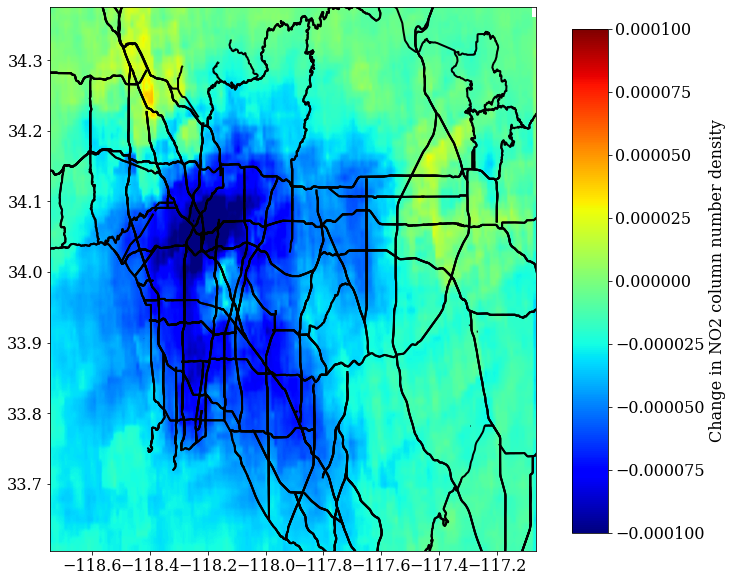

In [ ]:
# We can also compare the non-lockdown time (2019,2021,2022) with lockdown (2020) 
# by taking means across the numpy array and setting axis = 0
nonlockdown =  np.mean([image2019,image2021,image2022],axis=0)
lockdown =  np.mean([image2020],axis=0)

# remove zero values
nonlockdown[nonlockdown == 0] = np.nan
lockdown[lockdown == 0] = np.nan

# Then look at the difference
dNO2 =  lockdown - nonlockdown 

# Create figure object, axes, and subplots
fig, ax = plt.subplots(1,1,figsize =(10, 10))

roads.plot(ax=ax,color='k',linewidth=2)
change = ax.imshow(dNO2, extent=[lon.min(), lon.max(), lat.min(),lat.max()],vmin=-0.0001, vmax=0.0001, cmap='jet', aspect='auto')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(change, cax=cbar_ax,label='Change in NO2 column number density')
plt.show()

### Very clearly we can see a large decrease in NO2 (shown in blue) during COVID lockdown!
### This is centered around downtown Los Angeles

### Finally, plot some boxplots to look at the difference between lockdown/non-lockdown 

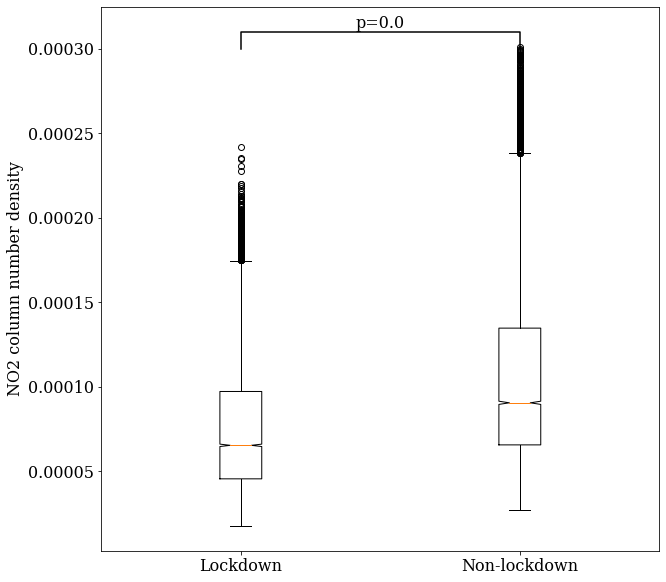

In [ ]:
# More visualization of data using boxplots
ld = lockdown.flatten()
nld = nonlockdown.flatten()

# remove nans 
ld = ld[~np.isnan(ld)]
nld = nld[~np.isnan(nld)]

# Create figure object, axes, and subplots
fig, ax = plt.subplots(1,1,figsize =(10, 10))

ax.boxplot([ld,nld],notch=1)

# statistical annotation
tvalue, pvalue = stats.ttest_ind(ld, nld)
x1, x2 = 1, 2   # columns 
y, h, col = 0.0003, 0.00001, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "p="+str(pvalue), ha='center', va='bottom', color=col)


ax.set_xticklabels(['Lockdown', 'Non-lockdown'])
ax.set_ylabel('NO2 column number density')
plt.show()